In [1]:
#Libraries
from matplotlib import pyplot
from numpy import savez_compressed, asarray, load
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import load
from numpy import expand_dims
from PIL import Image
import numpy as np
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import joblib
import cv2
import pickle

# Load models
path_to_model = "facenet_keras.h5"
model = load_model(path_to_model) #facenet
svc_model = joblib.load('svc3.sav') #SVC

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0] 

labels = ("Jose_Luis", "Patricia")
confidence = []
a = []
      
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
		# set labes
		if result != result_list[0]:                                       
			ax.text(x,y - 1, "Unknown", fontsize = 13, color = 'red')
		else:
			for i in range(len(labels)):
				if class_index == i:
					ax.text(x,y - 1,labels[i], fontsize = 13,color = 'red') 
	pyplot.show()

In [10]:
# load image from file
path = 'Inferencias/personal/patry.jpg'
filename = Image.open(path)
width, height = filename.size
if width >= 2000 and height >= 1270:
    newsize = (752, 478)
    filename = filename.resize(newsize)
    filename.save('Inferencias/personal/resize.jpg')
    filename = 'Inferencias/personal/resize.jpg'
    pixels = pyplot.imread(filename)
else:
    filename = path
    pixels = pyplot.imread(filename)

# create the detector, using default weights
detector = MTCNN()

# detect faces in the image
faces = detector.detect_faces(pixels)
# Extract faces in image
picture = extract_face(filename, required_size=(160, 160))
#savez_compressed('image.npz', picture)

# convert each face in the train set to an embedding
newTrainX = list()
embedding = get_embedding(model, picture)
newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(1, 128)


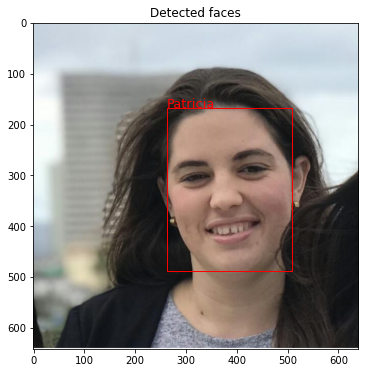

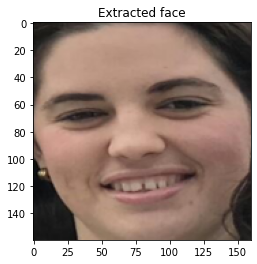

This is: Patricia
Class number: 1
Class probability: 100.0


In [11]:
# prediction for the face
yhat_class = svc_model.predict(newTrainX)
yhat_prob = svc_model.predict_proba(newTrainX)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100

# plot for fun
f, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6)) 
title = ('Detected faces')
pyplot.title(title)
draw_image_with_boxes(filename, faces)
title_2 = ('Extracted face')
pyplot.title(title_2)
pyplot.imshow(picture)
pyplot.show()

labels = ("Jose_Luis", "Patricia") 

for i in range(len(labels)):
    if class_index == i:
        print('This is:' + " " + str(labels[i]))
print('Class number:' + ' ' + str(class_index))
print('Class probability:' + ' ' + str(round(class_probability, 5)))